In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt # Import for plotting

In [31]:
INPUT_SIZE = 1 # Bending stiffness is the only input
OUTPUT_SIZE = 3 # Thickness, Height, Angle are outputs
LEARNING_RATE = 0.001
BATCH_SIZE = 32 # 
NUM_EPOCHS = 1000

TEST_SIZE = 0.2
RANDOM_STATE = 42
device = "cpu"

In [32]:
df = pd.read_csv(r'C:\Users\mason\Work\CMEC_SandwichPanel\Models\MLP\processed_bending_stiffness.csv')

# Remove duplicates
initial_count = len(df)
df = df.drop_duplicates()
removed_count = initial_count - len(df)
if removed_count > 0:
    print(f"Removed {removed_count} duplicate row(s) from the dataset.")
print(f"Shape of dataset after removing duplicates: {df.shape}")

X = df[['Bending_Stiffness']]
y = df[['Thickness', 'Height', 'Angle (deg)']] 

X_train, X_test, y_train, y_test = train_test_split(
    X.values, 
    y.values, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)
print(f"YTest headers:\n{y_test[:5]}")
DATASET_SIZE = len(df) # Number of samples

Removed 685 duplicate row(s) from the dataset.
Shape of dataset after removing duplicates: (743, 4)
YTest headers:
[[  7.236  51.739  46.9  ]
 [  6.713 117.335  69.5  ]
 [  8.18   93.69   64.9  ]
 [  5.571  24.436  64.9  ]
 [  4.427  26.159  50.9  ]]


In [33]:
model = nn.Sequential(
        nn.Linear(INPUT_SIZE, 64),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.2),

        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        
        # Output Layer
        nn.Linear(16, OUTPUT_SIZE)
).to(device)

In [34]:
X_train_tensor = torch.from_numpy(X_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Convert TESTING data to PyTorch Tensors
X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
y_test_tensor = torch.from_numpy(y_test.astype(np.float32))
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



--- Starting Training ---
Epoch [1/1000], Train Loss (t_loss): 36958.2849, Val Loss (v_loss): 3546.9052
Epoch [2/1000], Train Loss (t_loss): 8590.0279, Val Loss (v_loss): 3224.9978
Epoch [3/1000], Train Loss (t_loss): 4253.9321, Val Loss (v_loss): 3018.6214
Epoch [4/1000], Train Loss (t_loss): 2922.7666, Val Loss (v_loss): 2626.7519
Epoch [5/1000], Train Loss (t_loss): 2536.2053, Val Loss (v_loss): 2156.3438
Epoch [6/1000], Train Loss (t_loss): 2481.0425, Val Loss (v_loss): 2195.5674
Epoch [7/1000], Train Loss (t_loss): 2365.6939, Val Loss (v_loss): 2572.0379
Epoch [8/1000], Train Loss (t_loss): 2353.4084, Val Loss (v_loss): 2564.1617
Epoch [9/1000], Train Loss (t_loss): 2375.5307, Val Loss (v_loss): 2380.5770
Epoch [10/1000], Train Loss (t_loss): 2227.5819, Val Loss (v_loss): 2219.0192
Epoch [11/1000], Train Loss (t_loss): 2060.7530, Val Loss (v_loss): 1929.4354
Epoch [12/1000], Train Loss (t_loss): 1824.6842, Val Loss (v_loss): 1547.4236
Epoch [13/1000], Train Loss (t_loss): 1899.78

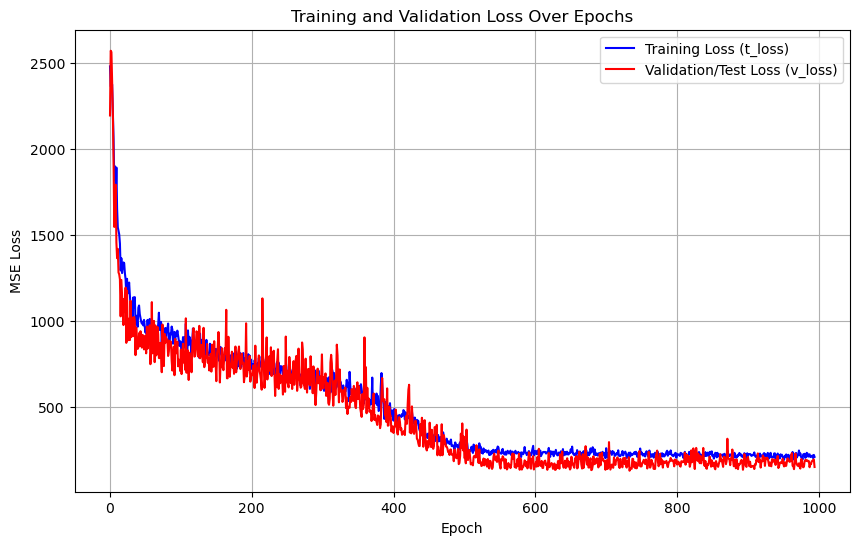

In [35]:
mae_criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Perhaps should use a validation set, but for now will use test set for validation
# Only using test set for monitoring of overfitting, model isn't actively changing based on it

trainLoss = []
validationLoss = []
print("\n--- Starting Training ---")
for epoch in range(NUM_EPOCHS):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * targets.size(0)
    
    avg_train_loss = running_loss / len(X_train)
    trainLoss.append(avg_train_loss) # Store the average training loss
    model.eval()
    running_val_loss = 0.0
    val_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            val_loss = criterion(outputs, targets) # Use the same loss for comparison
            running_val_loss += val_loss.item() * targets.size(0)
            val_samples += targets.size(0)
    
    avg_val_loss = running_val_loss / val_samples
    validationLoss.append(avg_val_loss) # Store the average validation loss
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss (t_loss): {avg_train_loss:.4f}, Val Loss (v_loss): {avg_val_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(trainLoss[5:], label='Training Loss (t_loss)', color='blue')
plt.plot(validationLoss[5:], label='Validation/Test Loss (v_loss)', color='red')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show() #



In [ ]:
print("\n--- Final Evaluation on Test Set ---")
model.eval()

total_loss = 0.0
total_samples = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        total_loss += loss.item() * targets.size(0)
        total_samples += targets.size(0)
        
        all_targets.append(targets.cpu())
        all_predictions.append(outputs.cpu())

targets_tensor = torch.cat(all_targets)
predictions_tensor = torch.cat(all_predictions)

mse = total_loss / total_samples
rmse = np.sqrt(mse)

mae_loss = nn.L1Loss()
mae = mae_loss(predictions_tensor, targets_tensor).item()

# Three vectors are currently being treated as a single output for R² calculation
# Perhaps should use per-dimension R² instead

# R-squared
target_mean = targets_tensor.mean()
ss_total = ((targets_tensor - target_mean) ** 2).sum().item()
ss_residual = ((predictions_tensor - targets_tensor) ** 2).sum().item()
r_squared = 1 - (ss_residual / ss_total) if ss_total != 0 else 0.0

print(f'\n--- Test Set Metrics ---')
print(f'MSE:  {mse:.6f}')
print(f'RMSE: {rmse:.6f}')
print(f'MAE:  {mae:.6f}')
print(f'R²:   {r_squared:.4f}')
print("\nTraining and Evaluation complete.")


--- Final Evaluation on Test Set ---
R²:
[0.07353408698498365, 0.6910243895991995, 0.2720302300641704]

--- Test Set Metrics ---
MSE:  151.524666
RMSE: 12.309536
MAE:  8.256471

Training and Evaluation complete.


In [42]:
print(model(torch.tensor([[802.0]], dtype=torch.float32)))  # Example bending stiffness input

tensor([[ 5.2384, 45.0226, 45.1613]], grad_fn=<AddmmBackward0>)
